In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
#from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# from coffea.processor.accumulator import column_accumulator
# from coffea.processor import accumulate
#from numba import njit
import vector
vector.register_numba()
vector.register_awkward()

from pprint import pprint 
hep.style.use(hep.style.ROOT)
import os
import hist

# Creating the parquet dataset

In [6]:
!ls /pnfs/psi.ch/cms/trivcat/store/user/dvalsecc/ttHbb/output_columns_parton_matching/sig_bkg_30_08_2023_v2

ttHTobb_forTraining_2016_PostVFP  ttHTobb_forTraining_2017
ttHTobb_forTraining_2016_PreVFP   ttHTobb_forTraining_2018


In [3]:
basedir= "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/sig_bkg_30_08_2023_v2/"
datasets =os.listdir(basedir)
for d in datasets:
    ak.to_parquet.dataset(basedir + f"{d}/semilep_LHE")    

# Loading the exported dataset

In [40]:
df = load("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/output_ttHTobb_fullRun2_v1.coffea")

In [4]:
df["cutflow"]

{'initial': {'ttHTobb_2018': 9668000,
  'ttHTobb_2016_PreVFP': 4622000,
  'ttHTobb_2016_PostVFP': 4937000,
  'ttHTobb_2017': 7825000},
 'skim': {'ttHTobb_2018': 1606848,
  'ttHTobb_2016_PreVFP': 595171,
  'ttHTobb_2016_PostVFP': 665949,
  'ttHTobb_2017': 1239523},
 'presel': {'ttHTobb_2018': 762553,
  'ttHTobb_2016_PreVFP': 251905,
  'ttHTobb_2016_PostVFP': 289373,
  'ttHTobb_2017': 585451},
 'baseline': {'ttHTobb_2018': {'ttHTobb': 762553},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 251905},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 289373},
  'ttHTobb_2017': {'ttHTobb': 585451}},
 'semilep_LHE': {'ttHTobb_2018': {'ttHTobb': 569646},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 188931},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 217062},
  'ttHTobb_2017': {'ttHTobb': 438491}}}

In [5]:
df["sumw"]

{'baseline': {'ttHTobb_2018': {'ttHTobb': 1258.8333048318555},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 296.2494175097036},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 274.0572408013326},
  'ttHTobb_2017': {'ttHTobb': 856.4419132989669}},
 'semilep_LHE': {'ttHTobb_2018': {'ttHTobb': 929.3939145075354},
  'ttHTobb_2016_PreVFP': {'ttHTobb': 220.62629025662434},
  'ttHTobb_2016_PostVFP': {'ttHTobb': 204.17366224287653},
  'ttHTobb_2017': {'ttHTobb': 633.8371764421364}}}

### Normalize the genweights

In [41]:
datasets = df["sum_genweights"].keys()
print("Datasets: ", datasets)

Datasets:  dict_keys(['ttHTobb_2018', 'ttHTobb_2016_PreVFP', 'ttHTobb_2016_PostVFP', 'ttHTobb_2017'])


In [42]:
for dataset in datasets:
    df["columns"]["ttHTobb"][dataset]["semilep_LHE"]["weight"] = column_accumulator(df["columns"]["ttHTobb"][dataset]["semilep_LHE"]["weight"] / df["sum_genweights"][dataset])

In [43]:
cs = accumulate([df["columns"]["ttHTobb"][dataset]["semilep_LHE"] for dataset in datasets])

partons = ak.unflatten(ak.zip({"pt": cs["Parton_pt"],
                              "eta": cs["Parton_eta"],
                              "phi": cs["Parton_phi"],
                               "mass": cs["Parton_mass"],
                              "pdgId": cs["Parton_pdgId"], 
                              "prov": cs["Parton_provenance"]},
                         with_name='Momentum4D'),
                     cs["Parton_N"])

partons_matched = ak.unflatten(ak.zip({"pt": cs["PartonMatched_pt"],
                              "eta": cs["PartonMatched_eta"],
                              "phi": cs["PartonMatched_phi"],
                              "mass": cs["PartonMatched_mass"],
                              "pdgId": cs["PartonMatched_pdgId"], 
                              "prov": cs["PartonMatched_provenance"]},
                         with_name='Momentum4D'),
                     cs["PartonMatched_N"])

jets = ak.unflatten(ak.zip({"pt": cs["JetGood_pt"],
                              "eta": cs["JetGood_eta"],
                              "phi": cs["JetGood_phi"],
                              "btag": cs["JetGood_btagDeepFlavB"],
                              "m": np.zeros(cs["JetGood_btagDeepFlavB"].shape)},
                         with_name='Momentum4D'),
                     cs["JetGood_N"])

jets_matched = ak.unflatten(ak.zip({"pt": cs["JetGoodMatched_pt"],
                              "eta": cs["JetGoodMatched_eta"],
                              "phi": cs["JetGoodMatched_phi"],
                              "btag": cs["JetGoodMatched_btagDeepFlavB"],
                              "prov": cs["PartonMatched_provenance"],
                              "m": np.zeros(cs["PartonMatched_provenance"].shape)},
                         with_name='Momentum4D'),
                     cs["JetGoodMatched_N"])


generator_info = ak.zip({"pdgid1": cs["Generator_id1"],
                              "pdgid2": cs["Generator_id2"],
                              "x1": cs["Generator_x1"],
                              "x2": cs["Generator_x2"]},
                         )


lepton_partons = ak.unflatten(ak.zip({"pt": cs["LeptonParton_pt"],
                              "eta": cs["LeptonParton_eta"],
                              "phi": cs["LeptonParton_phi"],
                              "mass": cs["LeptonParton_mass"],
                              "pdgId": cs["LeptonParton_pdgId"]},
                         with_name='Momentum4D'),
                     cs["LeptonParton_N"])


lepton = ak.zip({"pt": cs["LeptonGood_pt"],
                              "eta": cs["LeptonGood_eta"],
                              "phi": cs["LeptonGood_phi"],
                              "m": np.zeros(cs["LeptonGood_pt"].shape)},
                         with_name='Momentum4D')


met = ak.zip({"pt": cs["MET_pt"],
              "eta":  np.zeros(cs["MET_pt"].shape),
              "phi": cs["MET_phi"],
              "m": np.zeros(cs["MET_pt"].shape)},
         with_name='Momentum4D')

higgs = ak.zip({"pt": cs["HiggsParton_pt"],
                              "eta": cs["HiggsParton_eta"],
                              "phi": cs["HiggsParton_phi"],
                              "m": cs["HiggsParton_mass"]},
                         with_name='Momentum4D')


In [48]:
jets_matched = ak.mask(jets_matched, jets_matched.pt==-999, None)
partons_matched = ak.mask(partons_matched, partons_matched.pt==-999, None)
is_jet_matched = ~ak.is_none(jets_matched, axis=1)
jets = ak.with_field(jets, is_jet_matched, "matched")

# Filling with -1 the not matched provenance
jets = ak.with_field(jets, ak.fill_none(jets_matched.prov, -1), "prov")

Jets and partons_matched arrays are **aligned**.

In [49]:
dfout = ak.zip({
    "jets": jets,
    "partons_matched": partons_matched,
    "partons": partons,
    "generator_info": generator_info,
    "lepton_partons":lepton_partons,
    "lepton_reco": lepton,
    "met": met,
    "higgs": higgs
    }, depth_limit=1)

ak.to_parquet(dfout, "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_fullRun2_v1.parquet")

## Same outputs but from the parquet dataset

In [4]:
datasets

['ttHTobb_forTraining_2016_PostVFP',
 'ttHTobb_forTraining_2016_PreVFP',
 'ttHTobb_forTraining_2017',
 'ttHTobb_forTraining_2018']

In [11]:
outputdir = "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/sig_bkg_30_08_2023_v2/out_forTraining_sig_bkg"
os.makedirs(outputdir, exist_ok=True)

In [13]:
cs = ak.from_parquet(basedir + f"/ttHTobb_forTraining_2016_PreVFP/semilep_LHE", use_threads=4)

In [12]:
for dataset in datasets:
    print("Working on dataset: ", dataset)
    cs = ak.from_parquet(basedir + f"/{dataset}/semilep_LHE", use_threads=4)
    
    partons = ak.zip({"pt": cs["Parton_pt"],
                  "eta": cs["Parton_eta"],
                  "phi": cs["Parton_phi"],
                   "mass": cs["Parton_mass"],
                  "pdgId": cs["Parton_pdgId"], 
                  "prov": cs["Parton_provenance"]},
                             with_name='Momentum4D')

    partons_matched = ak.zip({"pt": cs["PartonMatched_pt"],
                                  "eta": cs["PartonMatched_eta"],
                                  "phi": cs["PartonMatched_phi"],
                                  "mass": cs["PartonMatched_mass"],
                                  "pdgId": cs["PartonMatched_pdgId"], 
                                  "prov": cs["PartonMatched_provenance"]},
                             with_name='Momentum4D')

    jets = ak.zip({"pt": cs["JetGood_pt"],
                                  "eta": cs["JetGood_eta"],
                                  "phi": cs["JetGood_phi"],
                                  "btag": cs["JetGood_btagDeepFlavB"],
                                  "m": ak.zeros_like(cs["JetGood_btagDeepFlavB"])},
                             with_name='Momentum4D')

    jets_matched = ak.zip({"pt": cs["JetGoodMatched_pt"],
                                  "eta": cs["JetGoodMatched_eta"],
                                  "phi": cs["JetGoodMatched_phi"],
                                  "btag": cs["JetGoodMatched_btagDeepFlavB"],
                                  "prov": cs["PartonMatched_provenance"],
                                  "m": ak.zeros_like(cs["PartonMatched_provenance"])},
                             with_name='Momentum4D')


    generator_info = ak.zip({"pdgid1": cs["Generator_id1"],
                                  "pdgid2": cs["Generator_id2"],
                                  "x1": cs["Generator_x1"],
                                  "x2": cs["Generator_x2"]},
                             )


    lepton_partons = ak.zip({"pt": cs["LeptonParton_pt"],
                                  "eta": cs["LeptonParton_eta"],
                                  "phi": cs["LeptonParton_phi"],
                                  "mass": cs["LeptonParton_mass"],
                                  "pdgId": cs["LeptonParton_pdgId"]},
                             with_name='Momentum4D')


    lepton = ak.zip({"pt": cs["LeptonGood_pt"],
                                  "eta": cs["LeptonGood_eta"],
                                  "phi": cs["LeptonGood_phi"],
                                  "m": ak.zeros_like(cs["LeptonGood_pt"])},
                             with_name='Momentum4D')


    met = ak.zip({"pt": cs["MET_pt"],
                  "eta":  ak.zeros_like(cs["MET_pt"]),
                  "phi": cs["MET_phi"],
                  "m": ak.zeros_like(cs["MET_pt"])},
             with_name='Momentum4D')

    if "HTobb" in dataset:
        higgs = ak.zip({"pt": cs["HiggsParton_pt"],
                                  "eta": cs["HiggsParton_eta"],
                                  "phi": cs["HiggsParton_phi"],
                                  "m": cs["HiggsParton_mass"]},
                             with_name='Momentum4D')


    jets_matched = ak.mask(jets_matched, jets_matched.pt==-999, None)
    partons_matched = ak.mask(partons_matched, partons_matched.pt==-999, None)
    is_jet_matched = ~ak.is_none(jets_matched, axis=1)
    jets = ak.with_field(jets, is_jet_matched, "matched")

    # Filling with -1 the not matched provenance
    jets = ak.with_field(jets, ak.fill_none(jets_matched.prov, -1), "prov")
    
    if "HTobb" in dataset:
        dfout = ak.zip({
            "jets": jets,
            "partons_matched": partons_matched,
            "partons": partons,
            "generator_info": generator_info,
            "lepton_partons":lepton_partons,
            "lepton_reco": lepton,
            "met": met,
            "higgs": higgs, 
            "weight": cs["weight"]
            }, depth_limit=1)
    else:
        dfout = ak.zip({
            "jets": jets,
            "partons_matched": partons_matched,
            "partons": partons,
            "generator_info": generator_info,
            "lepton_partons":lepton_partons,
            "lepton_reco": lepton,
            "met": met,
            "weight": cs["weight"]
            }, depth_limit=1)


    ak.to_parquet(dfout, f"{outputdir}/all_jets_fullRun2_{dataset}_v3.parquet")
#     if "HTobb" in dataset:
#         full_matched = (N_matched_parton == 7)
#         higgs_matched = N_matched_parton_higgs == 2
        
        
#     elif "TTbb"

#     print(f"There are {ak.sum(full_matched)} fully matched events")
#     print(f"There are {ak.sum(higgs_matched)} events with fully matched higgs")
    
#     dfout_full_matched = ak.zip({
#     "jets": jets[full_matched],
#     "partons_matched": partons_matched[full_matched],
#     "partons": partons[full_matched],
#     "generator_info": generator_info[full_matched],
#     "lepton_partons":lepton_partons[full_matched],
#     "lepton_reco": lepton[full_matched],
#     "met": met[full_matched],
#     "higgs": higgs[full_matched]
#     }, depth_limit=1)

#     ak.to_parquet(dfout_full_matched, f"/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_fullypartonmatched_{dataset}_fullRun2_v2.parquet")
    
#     dfout_higgs_matched = ak.zip({
#     "jets": jets[higgs_matched],
#     "partons_matched": partons_matched[higgs_matched],
#     "partons": partons[higgs_matched],
#     "generator_info": generator_info[higgs_matched],
#     "lepton_partons":lepton_partons[higgs_matched],
#     "lepton_reco": lepton[higgs_matched],
#     "met": met[higgs_matched],
#     "higgs": higgs[higgs_matched]
#     }, depth_limit=1)

#     ak.to_parquet(dfout_higgs_matched, f"/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_higgsmatched_{dataset}_fullRun2_v2.parquet")

Working on dataset:  ttHTobb_forTraining_2016_PostVFP
Working on dataset:  ttHTobb_forTraining_2016_PreVFP
Working on dataset:  ttHTobb_forTraining_2017
Working on dataset:  ttHTobb_forTraining_2018


#### Fully-matched dataset

(array([1.60000e+01, 4.39000e+02, 1.35380e+04, 2.13331e+05, 1.84078e+05,
        8.80100e+03, 5.05000e+02, 7.10000e+01, 1.30000e+01, 4.00000e+00]),
 array([-2.70340558e+09, -1.92218906e+09, -1.14097255e+09, -3.59756032e+08,
         4.21460483e+08,  1.20267700e+09,  1.98389351e+09,  2.76511003e+09,
         3.54632654e+09,  4.32754306e+09,  5.10875957e+09]),
 <BarContainer object of 10 artists>)

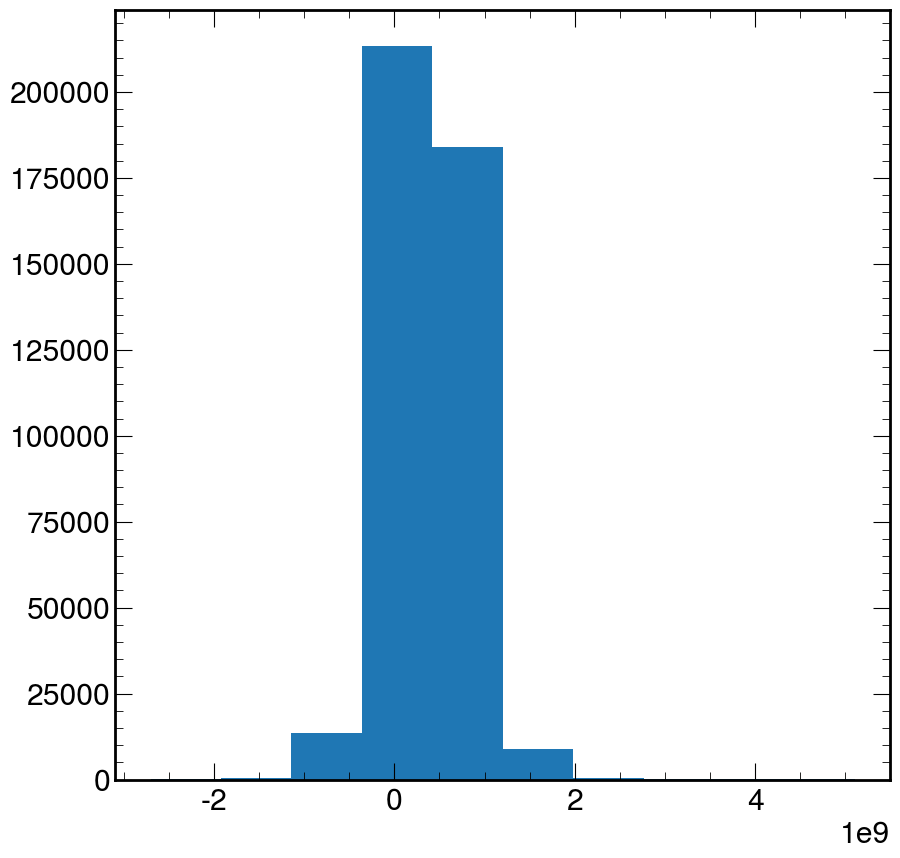

In [56]:
plt.hist(cs["weight"])

In [45]:
N_matched_parton = ak.sum(~ak.is_none(partons_matched, axis=1), axis=1)
N_matched_parton_higgs =  ak.sum(partons_matched.prov == 1, axis=1)

(array([   632.,   4621.,  31452., 161572., 347236.,  24110.,      0.,
             0.]),
 array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ]),
 <BarContainer object of 8 artists>)

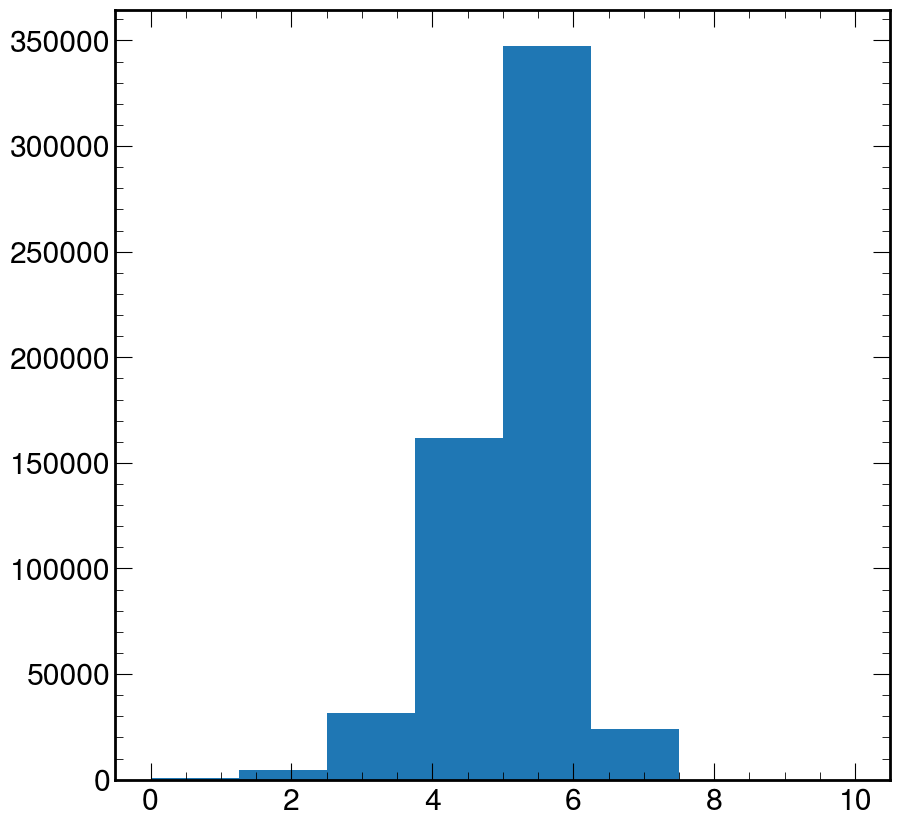

In [46]:
plt.hist(N_matched_parton, bins=8, range=(0, 10))

In [47]:
full_matched = (N_matched_parton == 7)
higgs_matched = N_matched_parton_higgs == 2

print(f"There are {ak.sum(full_matched)} fully matched events")
print(f"There are {ak.sum(higgs_matched)} events with fully matched higgs")

There are 24110 fully matched events
There are 341814 events with fully matched higgs


In [69]:
full_matched

<Array [False, False, False, ... False, False] type='1414130 * bool'>

In [70]:
dfout_full_matched = ak.zip({
    "jets": jets[full_matched],
    "partons_matched": partons_matched[full_matched],
    "partons": partons[full_matched],
    "generator_info": generator_info[full_matched],
    "lepton_partons":lepton_partons[full_matched],
    "lepton_reco": lepton[full_matched],
    "met": met[full_matched],
    "higgs": higgs[full_matched]
    }, depth_limit=1)

ak.to_parquet(dfout_full_matched, "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_fullypartonmatched_fullRun2_v1.parquet")

In [71]:
dfout_higgs_matched = ak.zip({
    "jets": jets[higgs_matched],
    "partons_matched": partons_matched[higgs_matched],
    "partons": partons[higgs_matched],
    "generator_info": generator_info[higgs_matched],
    "lepton_partons":lepton_partons[higgs_matched],
    "lepton_reco": lepton[higgs_matched],
    "met": met[higgs_matched],
    "higgs": higgs[higgs_matched]
    }, depth_limit=1)

ak.to_parquet(dfout_higgs_matched, "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_higgsmatched_fullRun2_v1.parquet")

In [16]:
# Now saving the "fully matched dataset", where all the events have all the partons matched

# Debugging plots

Text(1, 0, 'Events weight')

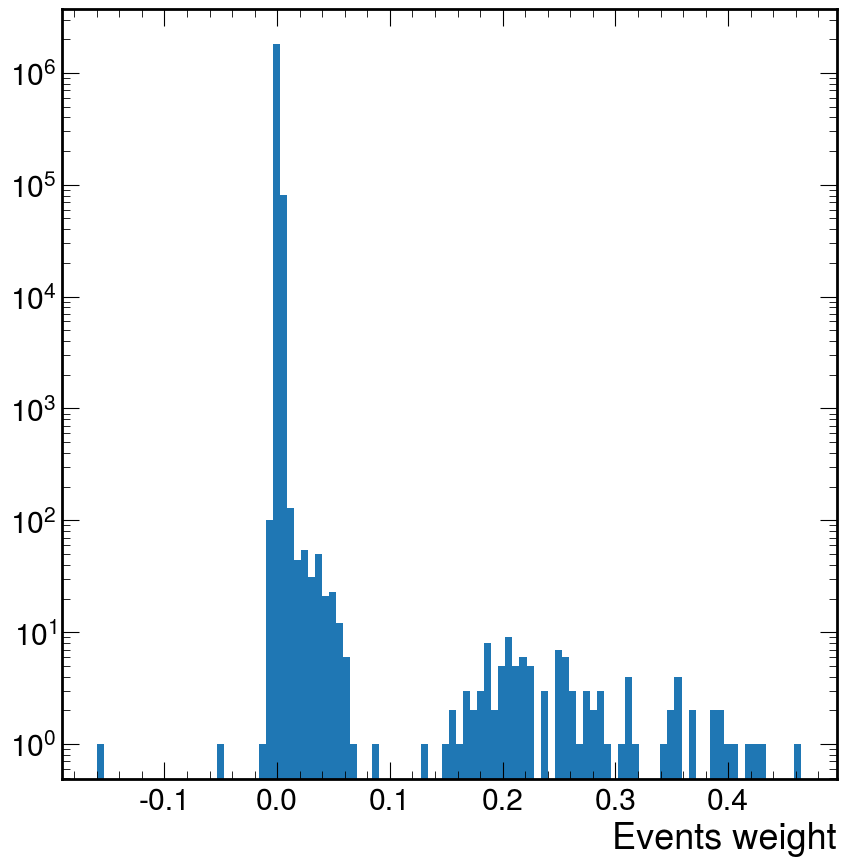

In [47]:
plt.hist(cs["weight"], bins=100)
plt.yscale("log")
plt.xlabel("Events weight")